In [37]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scikit_posthocs as sp


from scipy import stats


from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score,roc_curve, auc
from sklearn.decomposition import PCA

from imblearn.under_sampling import EditedNearestNeighbours




In [2]:
df = pd.read_csv("dataset_23_cmc.csv")
df

,Wifes_age,Wifes_education,Husbands_education,Number_of_children_ever_born,Wifes_religion,Wifes_now_working%3F,Husbands_occupation,Standard-of-living_index,Media_exposure,Contraceptive_method_used
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   Wifes_age                     1473 non-null   int64
 1   Wifes_education               1473 non-null   int64
 2   Husbands_education            1473 non-null   int64
 3   Number_of_children_ever_born  1473 non-null   int64
 4   Wifes_religion                1473 non-null   int64
 5   Wifes_now_working%3F          1473 non-null   int64
 6   Husbands_occupation           1473 non-null   int64
 7   Standard-of-living_index      1473 non-null   int64
 8   Media_exposure                1473 non-null   int64
 9   Contraceptive_method_used     1473 non-null   int64
dtypes: int64(10)
memory usage: 115.2 KB


In [4]:
target = "Contraceptive_method_used"

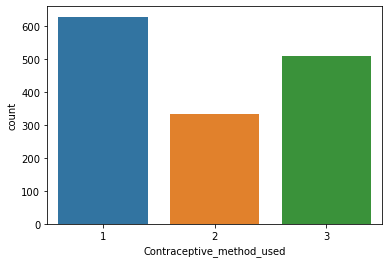

In [5]:
sns.countplot(x = df[target]);


**Normalização entre 0 - 1**

In [6]:
#normlizando 0 - 1
normalized_df = pd.DataFrame()
for i in df.columns:
    if i != target:
        normalized_df[i]=(df[i]-df[i].min())/(df[i].max()-df[i].min())
    else:
        normalized_df[i] = df[i]
        
normalized_df

,Wifes_age,Wifes_education,Husbands_education,Number_of_children_ever_born,Wifes_religion,Wifes_now_working%3F,Husbands_occupation,Standard-of-living_index,Media_exposure,Contraceptive_method_used
0,0.242424,0.333333,0.666667,0.1875,1.0,1.0,0.333333,0.666667,0.0,1
1,0.878788,0.000000,0.666667,0.6250,1.0,1.0,0.666667,1.000000,0.0,1
2,0.818182,0.333333,0.666667,0.4375,1.0,1.0,0.666667,1.000000,0.0,1
3,0.787879,0.666667,0.333333,0.5625,1.0,1.0,0.666667,0.666667,0.0,1
4,0.606061,0.666667,0.666667,0.5000,1.0,1.0,0.666667,0.333333,0.0,1
...,...,...,...,...,...,...,...,...,...,...
1468,0.515152,1.000000,1.000000,0.1250,1.0,0.0,0.333333,1.000000,0.0,3
1469,0.515152,1.000000,1.000000,0.1875,1.0,1.0,0.000000,1.000000,0.0,3
1470,0.696970,0.666667,0.666667,0.5000,1.0,0.0,0.000000,1.000000,0.0,3
1471,0.515152,0.666667,0.666667,0.2500,1.0,0.0,0.333333,0.333333,0.0,3


**EXPERIMENTO**

In [7]:
def classificador(model,X_train, X_test,y_train, y_test):
    
    
    if type(model).__name__ in ["SVC"] :
        y_t = label_binarize(y_train, classes=[1, 2, 3])
        y_te = label_binarize(y_test, classes=[1, 2,3])
        n_classes = y_t.shape[1]

        classifier = OneVsRestClassifier(model)

        aucs =[]
        y_score = classifier.fit(X_train, y_t).decision_function(X_test)
        for i in range(n_classes):
            fpr, tpr, AUC = roc_curve(y_te[:, i], y_score[:, i])
            aucs.append(auc(fpr,tpr))
            roc = sum(aucs)/3
        model.fit(X_train, y_train)
    else:
        model.fit(X_train, y_train)
        roc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')

    
    
    new_row = {"ACC":accuracy_score(y_test, model.predict(X_test)),
               "F1":f1_score(y_test, model.predict(X_test), average='weighted'),
                  "AUC":roc}

    matrix_confusao = confusion_matrix(y_test,model.predict(X_test))



    return (new_row, matrix_confusao)

#Mudar para plotar a matriz de confusão média
def plotMatrizConfusao(matriz_list):
    sum = [[0,0,0],[0,0,0],[0,0,0]]
    for i in range(len(matriz_list)):
        sum = sum + matriz_list[i]
        
            
    sns.heatmap(sum/len(matriz_list), annot=True)
    

In [56]:
def otimizadorDeHype(name,X_train,y_train):
    cv = 3
    if name=='knn':
        limite_superior = 100
        limite_inferior = 1 
        limite = list(range(limite_inferior,limite_superior))
        #Parametros a serem escolhidos
        params = {'n_neighbors':limite, 'metric':['euclidean','manhattan']}
        #istanciando 
        gridS = GridSearchCV(KNeighborsClassifier(),params,cv=cv,n_jobs=-1,scoring='accuracy')
        #treinando o grid 
        grid_result = gridS.fit(X_train,y_train)
        return KNeighborsClassifier(metric = grid_result.best_params_['metric'],
                                    n_neighbors = grid_result.best_params_['n_neighbors']  )
    
    if name== 'mlp':
        mlp = MLPClassifier(max_iter=1000)

        params = {
            'hidden_layer_sizes': [(8,8),(316,16),(32,32), (32,64), (64,128)],
            'activation': ['tanh', 'relu'],
            'solver':['sgd','adam'],
            'alpha':[0.0001, 0.05],
            'learning_rate': ['constante','adaptive'],
        }

        gridS = GridSearchCV(mlp,params,n_jobs=-1,cv=cv,scoring='accuracy')
        
        grid_result = gridS.fit(X_train,y_train)
        return MLPClassifier(hidden_layer_sizes=grid_result.best_params_['hidden_layer_sizes'], 
                    activation=grid_result.best_params_['activation'], solver=grid_result.best_params_['solver'],
                    alpha=grid_result.best_params_['alpha'],
                    learning_rate=grid_result.best_params_['learning_rate'], max_iter=100000)
    if name == 'df':
        
        df = DecisionTreeClassifier()
        params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': list(range(2, 10)),
                  'max_depth':list(range(2, 15)),'criterion':["gini", "entropy"]}
        
        gridS = GridSearchCV(df,params,cv=cv,n_jobs=-1,scoring='accuracy')
        
        grid_result = gridS.fit(X_train,y_train)
        return DecisionTreeClassifier(max_leaf_nodes = grid_result.best_params_['max_leaf_nodes'],
                                      min_samples_split=grid_result.best_params_['min_samples_split'] ,
                                     max_depth=  grid_result.best_params_['max_depth'],
                                     criterion = grid_result.best_params_['criterion'])
    if name == "nb":
        
        nb = GaussianNB()
        
        params = {'var_smoothing': np.logspace(0,-9, num=100)}
        
        gridS = GridSearchCV(nb,params,cv=cv,n_jobs=-1,scoring='accuracy')
        
        grid_result = gridS.fit(X_train,y_train)
        return GaussianNB(var_smoothing=grid_result.best_params_['var_smoothing'])
        
        return LogisticRegression(solver='liblinear', penalty=grid_result.best_params_['penalty'])
    if name == "svm":
        
        svm = SVC()
        
        params = {"kernel": ['rbf'], 'C': list(range(1, 100))}
        
        gridS = GridSearchCV(svm ,params,cv=cv,n_jobs=-1,scoring='accuracy')
                                                                                       
        grid_result = gridS.fit(X_train,y_train)
        return SVC(kernel=grid_result.best_params_['kernel'], C=grid_result.best_params_['C'])

In [57]:
def run(X, y, splits_kfold, pre=False, pca=False):
    kf = StratifiedKFold(n_splits=splits_kfold,random_state=42)
    kf.get_n_splits(X,y)

    metrics = ["ACC","F1","AUC"]


    matriz_knn = []
    matriz_tree = []
    matriz_mlp = []
    matriz_nb = []
    matriz_reg_log = []
    matriz_svm = []

    df_knn = pd.DataFrame(columns=metrics)
    df_tree = pd.DataFrame(columns=metrics)
    df_mlp = pd.DataFrame(columns=metrics)
    df_nb = pd.DataFrame(columns=metrics)
    df_reg_log = pd.DataFrame(columns=metrics)
    df_svm = pd.DataFrame(columns=metrics)



    for train_index, test_index in kf.split(X,y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if pre == True:
            resampler = EditedNearestNeighbours(n_neighbors=3, sampling_strategy="auto", kind_sel="mode")
            X_train, y_train = resampler.fit_resample(X_train, y_train)
        
        if pca == True:
            #PCA com 3 componetnes
            pca = PCA(n_components=3)
            X = pca.fit_transform(X)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            


        model = otimizadorDeHype("knn",X_train,y_train)
        line, matrix = classificador(model,X_train, X_test,y_train, y_test)
        df_knn = df_knn.append(line, ignore_index=True)
        matriz_knn.append(matrix)



        model = otimizadorDeHype("df",X_train,y_train)
        line, matrix = classificador(model,X_train, X_test,y_train, y_test)
        df_tree = df_tree.append(line, ignore_index=True)
        matriz_tree.append(matrix)   



        model = otimizadorDeHype("mlp",X_train,y_train)
        line, matrix = classificador(model,X_train, X_test,y_train, y_test)
        df_mlp = df_mlp.append(line, ignore_index=True)
        matriz_mlp.append(matrix)  


        model = otimizadorDeHype("nb",X_train,y_train)
        line, matrix = classificador(model,X_train, X_test,y_train, y_test)
        df_nb = df_nb.append(line, ignore_index=True)
        matriz_nb.append(matrix) 
        
        model = otimizadorDeHype("svm",X_train,y_train)
        line, matrix = classificador(model,X_train, X_test,y_train, y_test)
        df_svm = df_svm.append(line, ignore_index=True)
        matriz_svm.append(matrix)
        
    return [df_knn,df_tree,df_mlp,df_nb,df_svm ],[matriz_knn,matriz_tree,matriz_mlp,matriz_nb,matriz_svm]

In [58]:
X = normalized_df.drop(target, axis=1).values
y = normalized_df[target].values
splits_kfold = 3

## Treinamento sem Pré Processamento

In [59]:
dataframes,matrizes = run(X,y,splits_kfold)

C:\Users\bhla\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\bhla\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


## Treinamento com Pré Processamento ENN

In [60]:
dataframes_pre_enn, matrizes_pre_enn = run(X,y,splits_kfold,True,False)

C:\Users\bhla\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


## Treinamento com Pré Processamento PCA

In [61]:
dataframes_pre_pca, matrizes_pre_pca = run(X,y,splits_kfold,True,False)

C:\Users\bhla\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


## Experimento com Pré Processamento ENN + PCA

In [62]:
dataframes_pre_enn_pca, matrizes_pre_enn_pca = run(X,y,splits_kfold,True,True)

C:\Users\bhla\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


## Experimento com Pré Processamento PCA + ENN

In [63]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
dataframes_pre_pca_enn, matrizes_pre_pca_enn = run(X_pca,y,splits_kfold,True,False)

C:\Users\bhla\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


## Resultados

In [64]:
def result(dataframes,metrica):
    df_result = pd.DataFrame()
    metrica = metrica
    df_result["KNN"] = dataframes[0][metrica]
    df_result["TREE"] = dataframes[1][metrica]
    df_result["MLP"] = dataframes[2][metrica]
    df_result["NB"] = dataframes[3][metrica]
    df_result["SVM"] = dataframes[4][metrica]
    return df_result

**Acurácia Geral**

In [65]:
print("RESULTADO SEM PRE PROCESSAMENTO")
result(dataframes,"ACC").describe()

RESULTADO SEM PRE PROCESSAMENTO


,KNN,TREE,MLP,NB,SVM
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.494908,0.518669,0.558045,0.465037,0.524779
std,0.015376,0.027801,0.011340,0.021586,0.020603
min,0.478615,0.488798,0.547862,0.441955,0.501018
25%,0.487780,0.506110,0.551935,0.455193,0.518330
50%,0.496945,0.523422,0.556008,0.468432,0.535642
75%,0.503055,0.533605,0.563136,0.476578,0.536660
max,0.509165,0.543788,0.570265,0.484725,0.537678


In [66]:
print("RESULTADO COM PRE PROCESSAMENTO ENN")
result(dataframes_pre_enn,"ACC").describe()

RESULTADO COM PRE PROCESSAMENTO ENN


,KNN,TREE,MLP,NB,SVM
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.428377,0.488119,0.482010,0.437882,0.476578
std,0.012276,0.023605,0.024637,0.027400,0.018330
min,0.415479,0.472505,0.454175,0.415479,0.458248
25%,0.422607,0.474542,0.472505,0.422607,0.467413
50%,0.429735,0.476578,0.490835,0.429735,0.476578
75%,0.434827,0.495927,0.495927,0.449084,0.485743
max,0.439919,0.515275,0.501018,0.468432,0.494908


In [67]:
print("RESULTADO COM PRE PROCESSAMENTO PCA")
result(dataframes_pre_pca,"ACC").describe()

RESULTADO COM PRE PROCESSAMENTO PCA


,KNN,TREE,MLP,NB,SVM
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.428377,0.483367,0.490835,0.437882,0.476578
std,0.012276,0.010251,0.044667,0.027400,0.018330
min,0.415479,0.472505,0.441955,0.415479,0.458248
25%,0.422607,0.478615,0.471487,0.422607,0.467413
50%,0.429735,0.484725,0.501018,0.429735,0.476578
75%,0.434827,0.488798,0.515275,0.449084,0.485743
max,0.439919,0.492872,0.529532,0.468432,0.494908


In [68]:
print("RESULTADO COM PRE PROCESSAMENTO ENN+PCA")
result(dataframes_pre_enn_pca,"ACC").describe()

RESULTADO COM PRE PROCESSAMENTO ENN+PCA


,KNN,TREE,MLP,NB,SVM
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.428377,0.424983,0.443313,0.430414,0.431093
std,0.024468,0.032608,0.010047,0.011217,0.025789
min,0.403259,0.393075,0.431772,0.417515,0.411405
25%,0.416497,0.408350,0.439919,0.426680,0.416497
50%,0.429735,0.423625,0.448065,0.435845,0.421589
75%,0.440937,0.440937,0.449084,0.436864,0.440937
max,0.452138,0.458248,0.450102,0.437882,0.460285


In [69]:
print("RESULTADO COM PRE PROCESSAMENTO PCA+ENN")
result(dataframes_pre_pca_enn,"ACC").describe()

RESULTADO COM PRE PROCESSAMENTO PCA+ENN


,KNN,TREE,MLP,NB,SVM
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.416836,0.402580,0.427020,0.423625,0.419552
std,0.017559,0.022892,0.016336,0.008878,0.005388
min,0.401222,0.382892,0.411405,0.417515,0.413442
25%,0.407332,0.390020,0.418534,0.418534,0.417515
50%,0.413442,0.397149,0.425662,0.419552,0.421589
75%,0.424644,0.412424,0.434827,0.426680,0.422607
max,0.435845,0.427699,0.443992,0.433809,0.423625


**F1-Score Geral**

In [70]:
print("RESULTADO SEM PRE PROCESSAMENTO")
result(dataframes,"F1").describe()

RESULTADO SEM PRE PROCESSAMENTO


,KNN,TREE,MLP,NB,SVM
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.496068,0.512338,0.554167,0.466033,0.522254
std,0.012708,0.024781,0.010077,0.017893,0.018160
min,0.482937,0.489761,0.546575,0.446947,0.502311
25%,0.489949,0.499081,0.548451,0.457835,0.514462
50%,0.496960,0.508401,0.550327,0.468723,0.526614
75%,0.502634,0.523627,0.557963,0.475576,0.532226
max,0.508307,0.538852,0.565599,0.482428,0.537838


In [71]:
print("RESULTADO COM PRE PROCESSAMENTO")
result(dataframes_pre_enn,"F1").describe()

RESULTADO COM PRE PROCESSAMENTO


,KNN,TREE,MLP,NB,SVM
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.427814,0.486197,0.481024,0.429647,0.477541
std,0.013232,0.024888,0.020662,0.028055,0.016649
min,0.416292,0.470476,0.458986,0.402987,0.464780
25%,0.420589,0.471850,0.471556,0.415013,0.468125
50%,0.424886,0.473223,0.484127,0.427039,0.471469
75%,0.433575,0.494057,0.492043,0.442977,0.483922
max,0.442265,0.514890,0.499959,0.458914,0.496374


In [72]:
print("RESULTADO COM PRE PROCESSAMENTO PCA")
result(dataframes_pre_pca,"F1").describe()

RESULTADO COM PRE PROCESSAMENTO PCA


,KNN,TREE,MLP,NB,SVM
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.427814,0.483165,0.489394,0.429647,0.477541
std,0.013232,0.012194,0.040725,0.028055,0.016649
min,0.416292,0.470476,0.444661,0.402987,0.464780
25%,0.420589,0.477350,0.471933,0.415013,0.468125
50%,0.424886,0.484224,0.499205,0.427039,0.471469
75%,0.433575,0.489509,0.511761,0.442977,0.483922
max,0.442265,0.494795,0.524318,0.458914,0.496374


In [73]:
print("RESULTADO COM PRE PROCESSAMENTO ENN+PCA")
result(dataframes_pre_enn_pca,"F1").describe()

RESULTADO COM PRE PROCESSAMENTO ENN+PCA


,KNN,TREE,MLP,NB,SVM
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.423892,0.419716,0.360187,0.341186,0.392022
std,0.020336,0.034471,0.015227,0.010285,0.062312
min,0.400895,0.387857,0.345214,0.332648,0.340016
25%,0.416087,0.401420,0.352453,0.335477,0.357489
50%,0.431279,0.414982,0.359692,0.338306,0.374962
75%,0.435390,0.435646,0.367674,0.345455,0.418024
max,0.439502,0.456310,0.375655,0.352604,0.461086


In [74]:
print("RESULTADO COM PRE PROCESSAMENTO PCA+ENN")
result(dataframes_pre_pca_enn,"F1").describe()

RESULTADO COM PRE PROCESSAMENTO PCA+ENN


,KNN,TREE,MLP,NB,SVM
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.417081,0.398472,0.382990,0.340458,0.353730
std,0.019149,0.015615,0.035816,0.008224,0.021341
min,0.399512,0.384139,0.357274,0.332648,0.341116
25%,0.406874,0.390152,0.362536,0.336167,0.341410
50%,0.414237,0.396164,0.367797,0.339685,0.341705
75%,0.425865,0.405638,0.395848,0.344363,0.360038
max,0.437493,0.415112,0.423898,0.349041,0.378371


**AUC**

In [75]:
print("RESULTADO SEM PRE PROCESSAMENTO")
result(dataframes,"AUC").describe()

RESULTADO SEM PRE PROCESSAMENTO


,KNN,TREE,MLP,NB,SVM
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.675912,0.692925,0.724846,0.663273,0.687446
std,0.023195,0.026465,0.017953,0.035400,0.011342
min,0.659820,0.666739,0.710179,0.629292,0.680199
25%,0.662618,0.679557,0.714836,0.644941,0.680911
50%,0.665417,0.692375,0.719492,0.660589,0.681623
75%,0.683958,0.706018,0.732179,0.680264,0.691070
max,0.702499,0.719660,0.744866,0.699939,0.700518


In [76]:
print("RESULTADO COM PRE PROCESSAMENTO")
result(dataframes_pre_enn,"AUC").describe()

RESULTADO COM PRE PROCESSAMENTO


,KNN,TREE,MLP,NB,SVM
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.582526,0.651939,0.693449,0.652212,0.671851
std,0.008779,0.017856,0.026886,0.026594,0.014588
min,0.572731,0.632870,0.666197,0.626964,0.655081
25%,0.578946,0.643777,0.680196,0.638332,0.666973
50%,0.585162,0.654683,0.694194,0.649700,0.678864
75%,0.587423,0.661474,0.707074,0.664837,0.680236
max,0.589685,0.668264,0.719954,0.679973,0.681607


In [77]:
print("RESULTADO COM PRE PROCESSAMENTO PCA")
result(dataframes_pre_pca,"AUC").describe()

RESULTADO COM PRE PROCESSAMENTO PCA


,KNN,TREE,MLP,NB,SVM
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.582526,0.652074,0.689160,0.652212,0.671851
std,0.008779,0.010997,0.010831,0.026594,0.014588
min,0.572731,0.640007,0.676919,0.626964,0.655081
25%,0.578946,0.647345,0.684989,0.638332,0.666973
50%,0.585162,0.654683,0.693059,0.649700,0.678864
75%,0.587423,0.658108,0.695280,0.664837,0.680236
max,0.589685,0.661533,0.697502,0.679973,0.681607


In [78]:
print("RESULTADO COM PRE PROCESSAMENTO ENN+PCA")
result(dataframes_pre_enn_pca,"AUC").describe()

RESULTADO COM PRE PROCESSAMENTO ENN+PCA


,KNN,TREE,MLP,NB,SVM
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.589490,0.582020,0.631738,0.631239,0.619915
std,0.013349,0.023658,0.021845,0.021804,0.019584
min,0.579958,0.562737,0.610006,0.608523,0.607939
25%,0.581861,0.568820,0.620759,0.620859,0.608615
50%,0.583765,0.574904,0.631512,0.633194,0.609290
75%,0.594256,0.591662,0.642603,0.642597,0.625903
max,0.604746,0.608420,0.653695,0.652000,0.642515


In [79]:
print("RESULTADO COM PRE PROCESSAMENTO PCA+ENN")
result(dataframes_pre_pca_enn,"AUC").describe()

RESULTADO COM PRE PROCESSAMENTO PCA+ENN


,KNN,TREE,MLP,NB,SVM
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.577168,0.577663,0.634114,0.630333,0.625032
std,0.009921,0.017551,0.018471,0.020780,0.014223
min,0.566772,0.557769,0.617489,0.608386,0.611311
25%,0.572485,0.571014,0.624172,0.620647,0.617693
50%,0.578199,0.584258,0.630856,0.632907,0.624076
75%,0.582366,0.587609,0.642426,0.641307,0.631892
max,0.586532,0.590960,0.653997,0.649706,0.639709


## Matrizes

**KNN Resultados**

Plot das matrizes de confusão

RESULTADO SEM PRE PROCESSAMENTO


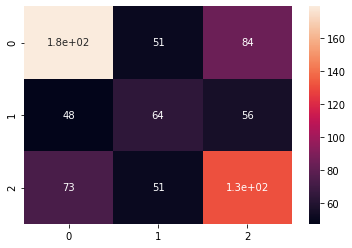

In [34]:
print("RESULTADO SEM PRE PROCESSAMENTO")
plotMatrizConfusao(matrizes[0])

**DT Resutaldos**

RESULTADO SEM PRE PROCESSAMENTO


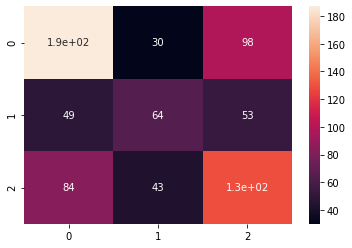

In [35]:
print("RESULTADO SEM PRE PROCESSAMENTO")
plotMatrizConfusao(matrizes[1])

**Multilayer Perceptron Resultados**

RESULTADO SEM PRE PROCESSAMENTO


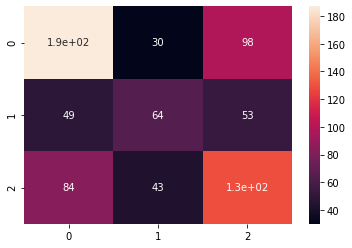

In [36]:
print("RESULTADO SEM PRE PROCESSAMENTO")
plotMatrizConfusao(matrizes[1])

**Naive Bayes Resultados**

RESULTADO SEM PRE PROCESSAMENTO


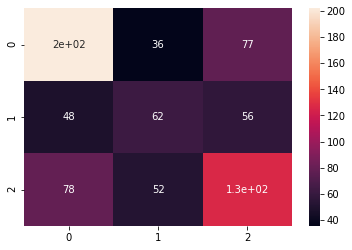

In [37]:
print("RESULTADO SEM PRE PROCESSAMENTO")
plotMatrizConfusao(matrizes[2])

**SVM**

RESULTADO SEM PRE PROCESSAMENTO


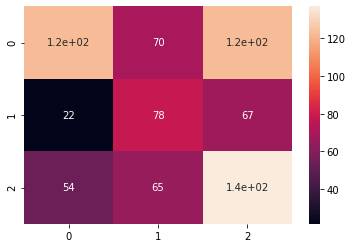

In [40]:
print("RESULTADO SEM PRE PROCESSAMENTO")
plotMatrizConfusao(matrizes[3])

## Teste estatisticos

**Shapiro-Wilk**

In [30]:
print("Teste de normalidade para as amostra das acurácias")
metrica = "ACC"
print(stats.shapiro(df_knn[metrica])[1])
print(stats.shapiro(df_nb[metrica])[1])
print(stats.shapiro(df_mlp[metrica])[1])
print(stats.shapiro(df_tree[metrica])[1])
print(stats.shapiro(df_reg_log[metrica])[1])
print(stats.shapiro(df_svm[metrica])[1])

Teste de normalidade para as amostra das acurácias
0.3197598159313202
0.82821124792099
0.5023860931396484
0.12150559574365616
0.6023426055908203
0.7127705216407776


In [31]:
print("Teste de normalidade para as amostra dos F1-score")
metrica = "F1"
print(stats.shapiro(df_knn[metrica])[1])
print(stats.shapiro(df_nb[metrica])[1])
print(stats.shapiro(df_mlp[metrica])[1])
print(stats.shapiro(df_tree[metrica])[1])
print(stats.shapiro(df_reg_log[metrica])[1])
print(stats.shapiro(df_svm[metrica])[1])

Teste de normalidade para as amostra dos F1-score
0.28937554359436035
0.9333374500274658
0.035092346370220184
0.27594178915023804
0.7954959869384766
0.9503359794616699


In [32]:
print("Teste de normalidade para as amostra da AUC da classe 1 contra todos")
metrica = "AUC"
print(stats.shapiro(df_knn[metrica])[1])
print(stats.shapiro(df_nb[metrica])[1])
print(stats.shapiro(df_mlp[metrica])[1])
print(stats.shapiro(df_tree[metrica])[1])
print(stats.shapiro(df_reg_log[metrica])[1])
print(stats.shapiro(df_svm[metrica])[1])

Teste de normalidade para as amostra da AUC da classe 1 contra todos
0.45864614844322205
0.4883570075035095
0.9851738810539246
0.9828658103942871
0.4018688499927521
0.385220468044281


**Teste Estátistico kruskal**

In [33]:
print("Valores de p para acuracia ")
print(stats.kruskal(df_knn["ACC"], df_nb["ACC"],df_mlp["ACC"],df_tree["ACC"],df_reg_log["ACC"],df_svm["ACC"]))

Valores de p para acuracia 
KruskalResult(statistic=29.877741899565763, pvalue=1.558868039232983e-05)


In [34]:
print("Valores de p para F1 ")
print(stats.kruskal(df_knn["F1"], df_nb["F1"],df_mlp["F1"],df_tree["F1"],df_reg_log["F1"],df_svm["F1"]))

Valores de p para F1 
KruskalResult(statistic=29.04918032786884, pvalue=2.2678104301602784e-05)


In [35]:
print("Valores de p para AUC 1 contra todos ")
print(stats.kruskal(df_knn["AUC"], df_nb["AUC"],df_mlp["AUC"],
                    df_tree["AUC"],df_reg_log["AUC"],df_svm["AUC"]))

Valores de p para AUC 1 contra todos 
KruskalResult(statistic=29.33442622950821, pvalue=1.993480144572561e-05)


**Teste Estátistico Dunn's**

In [36]:
print("Valores de p para acurácia: ")
print("KNN       NB       MLP       TREE       REG        SVM")
sp.posthoc_dunn([df_knn["ACC"], df_nb["ACC"],df_mlp["ACC"],df_tree["ACC"],df_reg_log["ACC"],df_svm["ACC"]] , p_adjust = 'bonferroni')


Valores de p para acurácia: 
KNN       NB       MLP       TREE       REG        SVM


,1,2,3,4,5,6
1,1.000000,0.988692,0.117488,0.176917,1.000000,1.00000
2,0.988692,1.000000,0.000103,0.000198,0.974638,0.02174
3,0.117488,0.000103,1.000000,1.000000,0.119742,1.00000
4,0.176917,0.000198,1.000000,1.000000,0.180162,1.00000
5,1.000000,0.974638,0.119742,0.180162,1.000000,1.00000
6,1.000000,0.021740,1.000000,1.000000,1.000000,1.00000


In [37]:
print("Valores de p para F1: ")
print("KNN       NB       MLP       TREE       REG        SVM")
sp.posthoc_dunn([df_knn["F1"], df_nb["F1"],df_mlp["F1"],df_tree["F1"],df_reg_log["F1"],df_svm["F1"]], p_adjust = 'bonferroni')

Valores de p para F1: 
KNN       NB       MLP       TREE       REG        SVM


,1,2,3,4,5,6
1,1.000000,0.950661,0.156675,0.277184,1.000000,1.000000
2,0.950661,1.000000,0.000150,0.000379,1.000000,0.034639
3,0.156675,0.000150,1.000000,1.000000,0.057122,1.000000
4,0.277184,0.000379,1.000000,1.000000,0.107572,1.000000
5,1.000000,1.000000,0.057122,0.107572,1.000000,1.000000
6,1.000000,0.034639,1.000000,1.000000,1.000000,1.000000


In [38]:
print("Valores de p para AUC 1 contra TODOS: ")
print("KNN       NB       MLP       TREE       REG        SVM")
sp.posthoc_dunn([df_knn["AUC"], df_nb["AUC"],df_mlp["AUC"],
                 df_tree["AUC"],df_reg_log["AUC"],df_svm["AUC"]], p_adjust = 'bonferroni')

Valores de p para AUC 1 contra TODOS: 
KNN       NB       MLP       TREE       REG        SVM


,1,2,3,4,5,6
1,1.000000,1.000000,0.002261,1.000000,1.000000,1.000000
2,1.000000,1.000000,0.000005,0.034639,0.162544,0.216975
3,0.002261,0.000005,1.000000,0.607533,0.162544,0.120608
4,1.000000,0.034639,0.607533,1.000000,1.000000,1.000000
5,1.000000,0.162544,0.162544,1.000000,1.000000,1.000000
6,1.000000,0.216975,0.120608,1.000000,1.000000,1.000000
